In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [2]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified ./notMNIST_large.tar.gz
Found and verified ./notMNIST_small.tar.gz


In [3]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

Extracting data for ./notMNIST_large. This may take a while. Please wait.
['./notMNIST_large/A', './notMNIST_large/B', './notMNIST_large/C', './notMNIST_large/D', './notMNIST_large/E', './notMNIST_large/F', './notMNIST_large/G', './notMNIST_large/H', './notMNIST_large/I', './notMNIST_large/J']
Extracting data for ./notMNIST_small. This may take a while. Please wait.
['./notMNIST_small/A', './notMNIST_small/B', './notMNIST_small/C', './notMNIST_small/D', './notMNIST_small/E', './notMNIST_small/F', './notMNIST_small/G', './notMNIST_small/H', './notMNIST_small/I', './notMNIST_small/J']


In [30]:
os.listdir('notMNIST_large/A')

['RW1wZXJvckVpZ2h0LnR0Zg==.png',
 'UGhvZW5peCBFeHRlbmRlZCBEIEl0YWxpYy50dGY=.png',
 'U2FpbGluZ0p1bmNvLnR0Zg==.png',
 'UXVlYmVjLUV4dHJhQm9sZC5vdGY=.png',
 'Q29uc3RydWN0aXZpc3QgRXh0cmFzLnR0Zg==.png',
 'YmlsbGllS2lkLnR0Zg==.png',
 'UmVnYWwgYm94LnR0Zg==.png',
 'SXZhbGVuY2lhLURlbWlCb2xkLm90Zg==.png',
 'QWRlbG9uLVJlZ3VsYXIub3Rm.png',
 'TG9nb3NDb21wYW55UDA4Lm90Zg==.png',
 'SmFuc29uIE9sZFN0eWxlIFNTaSBTbWFsbCBDYXBzLnR0Zg==.png',
 'U3RvbHplbmZlbHMub3Rm.png',
 'S25ld0ZvbnQgQm9sZC50dGY=.png',
 'T3JpZW50MSBOb3JtYWwudHRm.png',
 'U2NodWxzY2hyaWZ0QS1MNC5vdGY=.png',
 'U2hpdGhvdXNlLm90Zg==.png',
 'R2lua28udHRm.png',
 'R2lsbCBCbGFjayBTU2kgQmxhY2sudHRm.png',
 'QmVsd2VFRi1NZWRpdW0ub3Rm.png',
 'TWF0aGVtYXRpY2FsUGktVGhyZWUub3Rm.png',
 'V2hpdGVUaWVBZmZhaXJORi50dGY=.png',
 'SGVsdmV0aWNhTFRTdGQtQmxrT2JsLm90Zg==.png',
 'UXVvcnVtSVRDYnlCVC1NZWRpdW0ub3Rm.png',
 'U2Fib25CUS1Sb21hbi5vdGY=.png',
 'TW9yZ2FuU2Fuc0NvbmQtQm9sZE9mZmljZS5vdGY=.png',
 'U2Ftc29uIEJvbGQudHRm.png',
 'R2FtbWEgSVRDIFN0ZCBCb29rLm90Zg==.png',
 'TWV

In [31]:
display(Image(filename="notMNIST_small/A/Q0NXaWxkV29yZHMtQm9sZEl0YWxpYy50dGY=.png"))
display(Image(filename="notMNIST_large/A/a2F6b28udHRm.png"))
display(Image(filename="notMNIST_large/A/UXVlYmVjLUV4dHJhQm9sZC5vdGY=.png"))


In [39]:
#example of ndarray shape
np.ndarray(shape=(2,3,3), dtype=np.float32)

array([[[  9.21956299e-41,   9.21956299e-41,   9.18368975e-41],
        [  9.18368975e-41,   2.36935608e-38,   2.36942783e-38],
        [  2.36942783e-38,   2.36942783e-38,   2.36942783e-38]],

       [[  2.36942783e-38,   2.36942783e-38,   2.36942783e-38],
        [  2.36942783e-38,   2.36942783e-38,   2.36942783e-38],
        [  2.36942783e-38,   2.36942783e-38,   2.36942783e-38]]], dtype=float32)

In [4]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

Pickling ./notMNIST_large/A.pickle.
./notMNIST_large/A
Could not read: ./notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png : cannot identify image file './notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png' - it's ok, skipping.
Could not read: ./notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png : cannot identify image file './notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png' - it's ok, skipping.
Could not read: ./notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png : cannot identify image file './notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png' - it's ok, skipping.
Full dataset tensor: (52909, 28, 28)
Mean: -0.12825
Standard deviation: 0.443121
Pickling ./notMNIST_large/B.pickle.
./notMNIST_large/B
Could not read: ./notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png : cannot identify image file './notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png' - it's ok, skipping.
Full dataset tensor: (52911, 28, 28)
Mean: -0.00756304
Standard deviation: 0.454492
Pickl

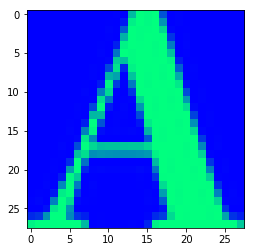

In [69]:
## checking some random images
pickle_file=train_datasets[0]
with open(pickle_file, 'rb') as f:
    letter_set=pickle.load(f) #unpickling the files
    sample_idx=np.random.randint(len(letter_set))
    sample_image=letter_set[sample_idx,:,:]
    plt.figure()
    plt.imshow(sample_image, cmap='winter')
    
    

In [83]:
#checking data is balanced
# we can also check the data is balanced across all classes using the output when pickling was done, still to be sure!!!
print("Check for Train Dataset ...")
for pickle_file in train_datasets:
    with open(pickle_file,'rb') as f:
        letter_set=pickle.load(f)
        print(pickle_file[-8:-7],' --> ', len(letter_set))
print("Check for Test Dataset ...")
for pickle_file in test_datasets:
    with open(pickle_file,'rb') as f:
        letter_set=pickle.load(f)
        print(pickle_file[-8:-7],' --> ', len(letter_set))



Check for Train Dataset ...
A  -->  52909
B  -->  52911
C  -->  52912
D  -->  52911
E  -->  52912
F  -->  52912
G  -->  52912
H  -->  52912
I  -->  52912
J  -->  52911
Check for Test Dataset ...
A  -->  1872
B  -->  1873
C  -->  1873
D  -->  1873
E  -->  1873
F  -->  1872
G  -->  1872
H  -->  1872
I  -->  1872
J  -->  1872


In [86]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


In [87]:
fileObject=open(train_datasets[1],'rb')
a=pickle.load(fileObject)

In [88]:
for i in enumerate(test_datasets):
    print (i)

(0, './notMNIST_small/A.pickle')
(1, './notMNIST_small/B.pickle')
(2, './notMNIST_small/C.pickle')
(3, './notMNIST_small/D.pickle')
(4, './notMNIST_small/E.pickle')
(5, './notMNIST_small/F.pickle')
(6, './notMNIST_small/G.pickle')
(7, './notMNIST_small/H.pickle')
(8, './notMNIST_small/I.pickle')
(9, './notMNIST_small/J.pickle')


In [89]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

In [90]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [98]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800503


In [92]:
test1Ddata=np.zeros([test_dataset.shape[0],784])
for i in range(test1Ddata.shape[0]):
    test1Ddata[i,:]=test_dataset[i,:,].ravel()

train1Ddata=np.zeros([train_dataset.shape[0],784])
for i in range(train1Ddata.shape[0]):
    train1Ddata[i,:]=train_dataset[i,:,].ravel()

valid1Ddata=np.zeros([valid_dataset.shape[0],784])
for i in range(valid1Ddata.shape[0]):
    valid1Ddata[i,:]=valid_dataset[i,:,].ravel()



In [93]:
import time
start=time.time()
nrows, ncols = test1Ddata.shape
dtype={'names':['f{}'.format(i) for i in range(ncols)],
       'formats':ncols * [test1Ddata.dtype]}
nrows,ncols=train1Ddata.shape
traindtype={'names':['f{}'.format(i) for i in range(ncols)],
       'formats':ncols * [train1Ddata.dtype]}
#print(dtype)
print(np.intersect1d(valid1Ddata.view(dtype),test1Ddata.view(dtype)).shape)
print(np.intersect1d(train1Ddata.view(traindtype),test1Ddata.view(dtype)).shape)
print(np.intersect1d(valid1Ddata.view(dtype),train1Ddata.view(traindtype)).shape)


total=time.time()-start
print(total)

(68,)
(1138,)
(969,)
20.629316568374634


In [94]:
def check_overlaps(images1, images2):
    images1.flags.writeable=False
    images2.flags.writeable=False
    start = time.clock()
    hash1 = set([hash(image1.tobytes()) for image1 in images1])
    hash2 = set([hash(image2.tobytes()) for image2 in images2])
    all_overlaps = set.intersection(hash1, hash2)
    return all_overlaps, time.clock()-start

r, execTime = check_overlaps(train_dataset, test_dataset)    
print('Number of overlaps between training and test sets: {}. Execution time: {}.'.format(len(r), execTime))

r, execTime = check_overlaps(train_dataset, valid_dataset)   
print('Number of overlaps between training and validation sets: {}. Execution time: {}.'.format(len(r), execTime))

r, execTime = check_overlaps(valid_dataset, test_dataset) 
print('Number of overlaps between validation and test sets: {}. Execution time: {}.'.format(len(r), execTime))

Number of overlaps between training and test sets: 1138. Execution time: 0.4166349999999852.
Number of overlaps between training and validation sets: 969. Execution time: 0.38521800000000894.
Number of overlaps between validation and test sets: 68. Execution time: 0.039141999999998234.


In [95]:
model=LogisticRegression(multi_class='multinomial', solver='lbfgs',random_state=42, verbose=1, max_iter=1000, n_jobs=-1)

In [96]:
model.fit(train1Ddata,train_labels)

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:718: UserWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number "
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 11.9min finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='multinomial',
          n_jobs=-1, penalty='l2', random_state=42, solver='lbfgs',
          tol=0.0001, verbose=1, warm_start=False)

In [97]:
model.score(test1Ddata,test_labels)

0.89749999999999996